# Adaptive PDE discretizations on cartesian grids 
## Volume : Divergence form PDEs
## Part : Linear elasticity
## Chapter : The wave equation

We use a novel [discretization of the linear elastic energy](ElasticEnergy.ipynb) to solve the elastic wave equation, in two dimensions.

<!---
and compare the first arrival times with those computed in the high frequency asymptotic using an eikonal equation.
--->

**Dimension two only.** Extending the numerical scheme presented in this notebook to dimension three requires an implementation of Voronoi's first reduction (a tool from lattice geometry) in dimension $6$, which is the dimension of the Hooke tensor. This is possible in principle, but it requires substantial work, and it is not currently available in the agd library, which only implements this tool in dimension $\leq 5$.

**Scheme order.**
We present both a second and a fourth order scheme in space. Regarding time, we use the Verlet first order symplectic scheme, which is actually second order up to a time shift by $\mathrm{d}t/2$.


[**Summary**](Summary.ipynb) of volume Divergence form PDEs, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Model analysis](#1.-Model-analysis)
    * [1.1 The Hamiltonian](#1.1-The-Hamiltonian)
    * [1.2 Choosing a material](#1.2-Choosing-a-material)
    * [1.3 Traveling waves](#1.3-Traveling-waves)
  * [2. Constant hooke tensor in space](#2.-Constant-hooke-tensor-in-space)
    * [2.1 Isotropic material](#2.1-Isotropic-material)
    * [2.2 Crystal (anisotropic)](#2.2-Crystal-(anisotropic))



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('ElasticityWave','Div'))

In [2]:
from agd import LinearParallel as lp
from agd import FiniteDifferences as fd
from agd.Metrics.Seismic import Hooke
from agd.Metrics.hamiltonian import QuadraticHamiltonian
from agd import AutomaticDifferentiation as ad
from agd import Domain
from agd.Plotting import savefig,quiver; #savefig.dirName = 'Images/ElasticityDirichlet'
norm_infinity = ad.Optimization.norm_infinity

from agd.ExportedCode.Notebooks_Div.ElasticEnergy import ElasticEnergy
mica,ρ = Hooke.mica # Note: ρ is in g/cm^3, which is inconsistent with the Hooke tensor SI units 

In [3]:
import numpy as np; xp=np; allclose=np.allclose
import matplotlib.pyplot as plt
import scipy.sparse; import scipy.sparse.linalg
from matplotlib import rc,animation; rc('animation', html='html5')

Utility functions.

In [4]:
def quiver_animation(X,Y,U,V,subsampling=tuple(),
                     figsize=None,axis=None,quiver_kwargs={},FAkwargs={}):
    """Animates a sequence of quiver plots."""
    where = tuple(slice(None,None,s) for s in subsampling)
    X,Y,U,V = (Z.__getitem__(where) for Z in (X,Y,U,V))
    fig, ax = plt.subplots(figsize=figsize); plt.close()
    if axis is not None: ax.axis(axis)
    Um,Vm = (np.mean(np.abs(E),axis=-1) for E in (U,V)) # Mean values for correct scaling
    quiv = ax.quiver(X,Y,Um,Vm,**quiver_kwargs)
    def func(i,Y): quiv.set_UVC(U[...,i],V[...,i]) 
    FAkwargs.setdefault('interval',20)
    FAkwargs.setdefault('repeat',False)
    return animation.FuncAnimation(fig,func,fargs=(Y,),frames=U.shape[-1],**FAkwargs)

In [5]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global Hooke
    Hooke, = rreload((Hooke,),rootdir="../..")

### 0.1 Additional configuration

Uncomment the following line to use GPU acceleration.

In [6]:
#xp,plt,quiver,mica,allclose = map(ad.cupy_friendly,(xp,plt,quiver,mica,allclose))

## 1. Model analysis


### 1.1 The Hamiltonian


The Hamiltonian of the elastic wave equation is separable, and is the sum of two quadratic terms: the kinetic energy, and the elastic energy.
$$
    H(v,m) = \frac 1 2 \int_\Omega c(\epsilon,\epsilon) + \frac{\|m\|^2}{\rho},
$$
where $c$ is the Hooke tensor, $\epsilon$ is the stress tensor, $m$ is the momentum density, and $\rho$ is the material density.
The finite differences approximation of $c(\epsilon,\epsilon)$ is the subject of [another notebook](ElasticEnergy.ipynb). In order to complete our Hamiltonian, we thus only need to discretize the kinetic energy.

In [7]:
def KineticEnergy(m,ρ):
    """Squared norm of the momentum, divided by the density, 
    which is (twice) the kinetic energy density."""
    return (m**2).sum(axis=0) / ρ

Based on the earlier discussion along the [discretization of $c(\epsilon,\epsilon)$](ElasticEnergy.ipynb), and on the [wave equation CFL condition](Time1D_Div.ipynb), we obtain a CFL condition (somewhat pessimistic) for the wave equation. 

In [8]:
def CFL(dx,hooke,ρ,order=1):
    """Largest time step guaranteed to be stable for the elastic wave equation"""
    tr = lp.trace(hooke.to_Mandel())
    L = (0,16,78)[order] # See elastic energy notebook
    return 2*dx / np.sqrt(L * ρ * tr)

### 1.2 Choosing a material

We collected a few examples of material elasticity tensors and density, for illustration purposes. For simplicity, we use a constant material, and a periodic domain.

In [9]:
hooke = mica.extract_xz().rotate_by(0.5)
crystal_material = (hooke,ρ)

For the purposes of illustration, we also consider a simpler isotropic material, defined by unit Lame coefficients $\lambda=\mu=1$, and unit density $\rho=1$.

In [10]:
hooke = Hooke.from_Lame(xp.array(1.),1.)
ρ = 1.
isotropic_material = (hooke, ρ)

We are now in position to introduce the full hamiltonian, for a periodic domain at least. 

<!---
The following does not work, because AD simplification must occur before summation
--->

<!---
def Hamiltonian(hooke,ρ,dom,**kwargs):
    """Returns the Hamiltonian of the linear elastic wave equation."""
    Hq = lambda q: 0.5 * ElasticEnergy(q,hooke,dom,**kwargs).sum() * h**2 
    Hp = lambda p: 0.5 * KineticEnergy(p,ρ).sum() * h**2

    H = Metrics.Hamiltonian( (Hq, Hp), shape_free = X.shape, inv_inner=h**-2 )
#    H.separable_quadratic_set_sparse_matrices(simplify_ad=2)
    return H
--->

In [11]:
def WaveHamiltonian(hooke,ρ,dom,order=1):
    """Returns the Hamiltonian of the linear elastic wave equation."""
    # Summation is implicit, and purposedly not done here (for simplify_ad)
    h = dom.gridscale
    Hq = lambda q: 0.5 * ElasticEnergy(q,hooke,dom,order=order) * h**2 
    Hp = lambda p: 0.5 * KineticEnergy(p,ρ) * h**2
    H = QuadraticHamiltonian(Hq,Hp,inv_inner=h**-2)
    z = np.zeros((dom.vdim,*dom.shape)) # Correctly shaped placeholder for position or impulsion
    H.set_spmat(z) # Replaces quadratic functions with sparse matrices
    return H 

### 1.3 Traveling waves

Traveling waves are eigenmodes of the wave equation. In the case of elastic materials, several waves of different velocities may travel in the same direction. The fastest is known as the *pressure wave*. There also exists two independent shear waves in three dimension, and a single one in two dimensions.

Traveling waves take the form
$$
    V \cos(k\cdot x - \omega t+\phi),
$$
where $k$ is the wave number, $\omega$ is the pulsation, $V$ is the amplitude, and $\phi$ is a phase shift. Given the wave vector $k$, there exists $d$ possible pulsations, and $d$ possible amplitudes (up to multiplication by a scalar).

In [12]:
def wave(t,x,ω,k,V,ϕ=0.):
    t,x,ω,k,V = fd.common_field((t,x,ω,k,V),depths=(0,1,0,1,1))
    return V*np.cos(lp.dot_VV(k,x)-ω*t+ϕ)

The `Hooke` class provides a method for computing the (normalized) amplitude and pulsation associated to a wave vector.

In [13]:
k = [0.6,0.8]
hooke,ρ = isotropic_material
ω,V = hooke.waves(k,ρ)

In dimension two, there are two wave modes. The fastest mode, associated with the largest pulsation, is the pressure wave.

In [14]:
print(f"Wave pulsations {ω} for wave vector {k}")

Wave pulsations [1.         1.73205081] for wave vector [0.6, 0.8]


In isotropic materials, the amplitude of the pressure wave is collinear with the wave vector, whereas the amplitude of shear waves is orthogonal to the wave vector.

In [15]:
print(f"Amplitude of the shear wave: {V[:,0]}, and pressure wave: {V[:,1]}")

Amplitude of the shear wave: [-0.8  0.6], and pressure wave: [0.6 0.8]


This property is lost in anisotropic materials. The amplitude of the shear and pressure waves is neither collinear nor orthogonal to the wave vector.

In [16]:
k = [0.6,0.8]
hooke,ρ = crystal_material
ω,V = hooke.waves(k,ρ)
print(f"Amplitude of the shear wave: {V[:,0]}, and pressure wave: {V[:,1]}, for wave vector {k}.")

Amplitude of the shear wave: [ 0.54538986 -0.8381825 ], and pressure wave: [-0.8381825  -0.54538986], for wave vector [0.6, 0.8].


Let us check, using automatic differentiation, the we do obtain eigenmodes of the wave equation, in the case of a constant hooke tensor and density.
This equation reads
$$
    \rho \frac{\partial^2}{\partial t^2} v_i = \sum_{j,k,l} c_{ijkl} \frac{\partial^2}{\partial x_j\partial x_k} v_l. 
$$

In [17]:
def WaveModes(k,hooke,ρ):
    """Returns the wave modes, sorted by increasing velocity, 
    associated with a given Hooke tensor and wave vector"""
    def wave_(ω,V): return lambda t,x : wave(t,x,ω,k,V)
    ω_,V_ = hooke.waves(k,ρ)
    return [wave_(ω,V) for ω,V in zip(ω_,V_.T)]

In [18]:
def WaveResidue(t,x,v,hooke,ρ):
    # Differentiate twice w.r.t time
    t_ad = ad.Dense2.identity(constant=t)
    v_tt = v(t_ad,x).hessian(0,0)
    
    # Differentiate twice w.r.t position
    x_ad = ad.Dense2.identity(constant=x)
    v_xx = v(t,x_ad).hessian() # Axes ordering : partial derivatives, then coordinates.
    
    # Contract with the Hooke tensor
    d = hooke.vdim
    hk = hooke.to_depth4() # Format hooke tensor as a depth 4 tensor
    Δv = sum(hk[:,j,k,l]*v_xx[j,k,l] for j in range(d) for k in range(d) for l in range(d))

    return ρ*v_tt - Δv

In [19]:
t,x = 1.,[2.,3.]; material = isotropic_material
shearW,pressW = WaveModes(k,*material)
assert allclose(WaveResidue(t,x,shearW,*material), 0.)
assert allclose(WaveResidue(t,x,pressW,*material), 0.)

In [20]:
t,x = 1.,[2.,3.]; material = crystal_material
shearW,pressW = WaveModes(k,*material)
assert allclose(WaveResidue(t,x,shearW,*material), 0.)
assert allclose(WaveResidue(t,x,pressW,*material), 0.)

## 2. Constant material in space

We compute elastic waves in a constant material, either isotropic or crystalline, in a periodic domain.

In [21]:
# Periodic domain [-1,1]^2
aX,dx = xp.linspace(-1,1,endpoint=False,retstep=True)
X=ad.array(np.meshgrid(aX,aX,indexing='ij'))
dom = Domain.MockDirichlet(X.shape[1:],dx,padding=None) #Periodic domain (wrap instead of pad)

### 2.1 Isotropic material

First let us set the Hamiltonian, governing the wave equation, and the time step.

In [22]:
#hooke = isotropic_material[0]
#hooke.Selling()
#z = xp.zeros((10,10))
#fd.DiffUpwind(z,xp.array((1,0),dtype=int))

In [23]:
material = isotropic_material
WaveH = WaveHamiltonian(*material,dom)
dt = CFL(dx,*material)

Then, we choose an initial condition, beginning with periodic waves for simplicity.

In [24]:
k = [np.pi,0.] 
shearW,pressW = WaveModes(k,*material)

**Pressure wave.**
We consider a pressure wave, propagating along the $x$-axis, space periodic for simplicity.

The initial condition is set as the analytic wave mode, but the time evolution is computed using the hamiltonian.

In [25]:
q0 = pressW(0,X) # Initial displacement
t_ad = ad.Dense.identity(constant=0.)
p0 = pressW(t_ad,X).gradient(0) * 1. # Initial momentum (rho=1.)

Q,P,T = WaveH.integrate(q0,p0,scheme='Verlet-p',niter=100,dt=dt,path=True)

For these domain sizes, the computation of the propagation is almost instantaneous, but the HTML5 encoding of the animation may take a little longer.

In [26]:
quiver_animation(*X,*Q,subsampling=(2,2),figsize=(6,6),axis='equal')

**Shear wave.** The Shear wave is slightly slower, and oscillates in the orthogonal direction, while propagating likewise along the $x$-axis.

In [27]:
q0 = shearW(0,X) # Initial displacement
t_ad = ad.Dense.identity(constant=0.)
p0 = shearW(t_ad,X).gradient(0) * 1. # Initial momentum (rho=1.)

Q,P,T = WaveH.integrate(q0,p0,scheme='Verlet-p',niter=100,dt=dt,path=True)

In [28]:
quiver_animation(*X,*Q,subsampling=(2,2),figsize=(6,6),axis='equal')

**Explosion.** We trigger a pressure wave in all directions, emulating an explosion.

In [29]:
def gaussian(X,σ): return np.exp(-lp.dot_VV(X,X)/(2*σ**2)) # Non normalized gaussian with prescribed variance
X_ad = ad.Dense.identity(constant=X,shape_free=(2,))
explosion = -gaussian(X_ad,0.1).gradient()

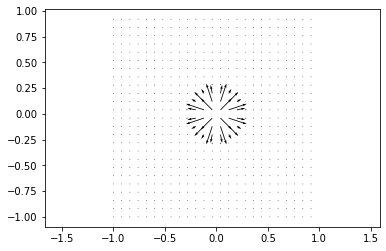

In [30]:
plt.axis('equal')
quiver(*X,*explosion,subsampling=(2,2),scale=100.)

In [31]:
q0 = np.zeros_like(X)
p0 = explosion

Q,P,T = WaveH.integrate(q0,p0,scheme='Verlet-p',niter=80,dt=dt,path=True)

In [32]:
quiver_animation(*X,*Q,subsampling=(2,2),figsize=(6,6),axis='equal',quiver_kwargs={'scale':5.})

**Torsion.** We rotate the explosion initial momentum by $\pi/2$ to trigger shear waves in all directions.

In [33]:
torsion = np.array((explosion[1],-explosion[0])) # Perpendicular vector

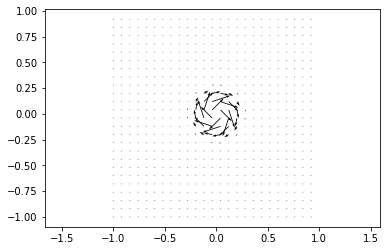

In [34]:
plt.axis('equal')
quiver(*X,*torsion,subsampling=(2,2),scale=100.)

In [35]:
q0 = np.zeros_like(X)
p0 = torsion

Q,P,T = WaveH.integrate(q0,p0,scheme='Verlet-p',niter=140,dt=dt,path=True)

In [36]:
quiver_animation(*X,*Q,subsampling=(2,2),figsize=(6,6),axis='equal',quiver_kwargs={'scale':5.})

### 2.2 Crystal material (anisotropic)

We reproduce the experiments of the previous section, replacing the isotropic material with a the (rotated) mica crystal.

In [37]:
material = crystal_material
WaveH = WaveHamiltonian(*material,dom)
dt = 2*CFL(dx,*material) # CFL estimation is too conservative

**Pressure and shear waves.**
As before, we begin with periodic waves obtained as eigenmodes of the equation.

In [38]:
k = [np.pi,0.] 
shearW,pressW = WaveModes(k,*material)

In [39]:
q0 = pressW(0,X) # Initial displacement
t_ad = ad.Dense.identity(constant=0.)
p0 = pressW(t_ad,X).gradient(0) * 1. # Initial momentum (rho=1.)

Q,P,T = WaveH.integrate(q0,p0,scheme='Verlet-p',niter=100,dt=dt,path=True)

The oscillation direction of the pressure waves is not anymore parallel to their propagation direction.

In [40]:
quiver_animation(*X,*Q,subsampling=(2,2),figsize=(6,6),axis='equal')

In [41]:
q0 = shearW(0,X) # Initial displacement
t_ad = ad.Dense.identity(constant=0.)
p0 = shearW(t_ad,X).gradient(0) * 1. # Initial momentum (rho=1.)

Q,P,T = WaveH.integrate(q0,p0,scheme='Verlet-p',niter=140,dt=dt,path=True)

Likewise, the shear waves do not anymore oscillate in a direction orthogonal to their direction of propagation.

In [42]:
quiver_animation(*X,*Q,subsampling=(2,2),figsize=(6,6),axis='equal')

**Explosion and torsion**

In [43]:
q0 = np.zeros_like(X)
p0 = explosion

Q,P,T = WaveH.integrate(q0,p0,scheme='Verlet-p',niter=80,dt=dt,path=True)

In [44]:
quiver_animation(*X,*Q,subsampling=(2,2),figsize=(6,6),axis='equal',quiver_kwargs={'scale':0.3})

In [45]:
q0 = np.zeros_like(X)
p0 = torsion

Q,P,T = WaveH.integrate(q0,p0,scheme='Verlet-p',niter=140,dt=dt,path=True)

In [46]:
quiver_animation(*X,*Q,subsampling=(2,2),figsize=(6,6),axis='equal',quiver_kwargs={'scale':0.3})

### 2.3 Fourth order scheme

The fourth order scheme seems to raise no particular issue. 

In [47]:
material = crystal_material
WaveH = WaveHamiltonian(*material,dom,order=2)
dt = 2*CFL(dx,*material,order=2) # CFL estimation is too conservative

In [48]:
q0 = np.zeros_like(X)
p0 = torsion

Q,P,T = WaveH.integrate(q0,p0,scheme='Verlet-p',niter=280,dt=dt,path=True)

In [49]:
quiver_animation(*X,*Q[...,::2],subsampling=(2,2),figsize=(6,6),axis='equal',quiver_kwargs={'scale':0.3})